# In this notebook we will analysie de quickquasar mock catalog using picca

#### If you dont have picca, you can clone the repository from: https://github.com/igmhub/picca

In [ ]:
#this will add picca to your pythonpath
import sys
sys.path.append('/global/homes/o/olegbg/picca/py')


In [2]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sb
from picca.converters import desi_from_ztarget_to_drq
import picca.wedgize
sb.set_style('white')

#### Load the zcatalog generated in the previous notebook 

In [3]:
path_zcat = '/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/zcat.fits' #path to the zcatalog
path_out = "/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/catalog/zcat_desi_drqv4.fits" #path to the output drq catalog

#### Next we need to change the format of the zcatlog to one that picca can read

In [4]:
# this will calculate the drq catalog needed to calculate the deltas from the spectra
desi_from_ztarget_to_drq(in_path=path_zcat,out_path=path_out,spec_type="QSO")

 start               : nb object in cat = 267810
 and zwarn==0        : nb object in cat = 267810
 and spectype==QSO    : nb object in cat = 267810


# How to calculate the deltas

#### For tutorial this we can use the deltas.sh script. This will take ~10 minutes for the mock used in this tutorial (downsampling = 0.1).

# We can look at the output of the deltas

In [5]:
path_deltas = '/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/Delta_lya'

In [6]:
data_deltas = fitsio.FITS(path_deltas + '/log/delta_attr.fits.gz')

In [7]:
data_deltas[4]


  file: /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/Delta_lya/log/delta_attr.fits.gz
  extension: 4
  type: BINARY_TBL
  extname: VAR
  rows: 20
  column info:
    var_pipe            f8  array[100]
    var_del             f8  array[100]
    var2_del            f8  array[100]
    count               f8  array[100]
    nqsos               f8  array[100]
    chi2                f8  

#### we can look at the flux obtained from picca_deltas.py

Text(0, 0.5, '$\\mathrm{\\overline{Flux}}$')

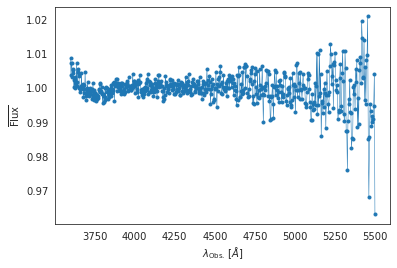

In [8]:
loglam = data_deltas[1]['LOGLAM'][:]
stack  = data_deltas[1]['STACK'][:]
cut = (stack!=0.) & (data_deltas[1]['WEIGHT'][:]>0.)
loglam = loglam[cut]
stack  = stack[cut]
plt.plot(10.**loglam, stack, linewidth=.5,marker='.');
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$')
plt.ylabel(r'$\mathrm{\overline{Flux}}$')

Text(0, 0.5, '$\\mathrm{\\overline{Flux}}$')

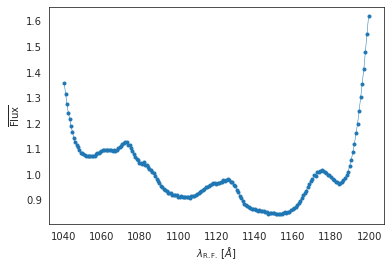

In [9]:
loglam_rest = data_deltas[3]['LOGLAM_REST'][:]
mean_cont   = data_deltas[3]['MEAN_CONT'][:]
cut = (mean_cont!=0.) & (data_deltas[3]['WEIGHT'][:]>0.)
loglam_rest = loglam_rest[cut]
mean_cont   = mean_cont[cut]
plt.plot(10.**loglam_rest, mean_cont, linewidth=0.5,marker='.')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\AA]$')
plt.ylabel(r'$\mathrm{\overline{Flux}}$')

# The correlation function 
#### After running the deltas, we can compute the correlations using the corrs.sh script. This will take ~20 minutes

In [10]:
path_corrs = '/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/correlations/'

In [11]:
data = fitsio.FITS(path_corrs + 'e_cf.fits.gz')

In [12]:
data['COR']


  file: /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/correlations/e_cf.fits.gz
  extension: 1
  type: BINARY_TBL
  extname: COR
  rows: 2500
  column info:
    RP                  f8  
    RT                  f8  
    Z                   f8  
    DA                  f8  
    CO                  f8  array[2500]
    DM                  f8  array[2500]
    NB                  i8  

In [13]:
da = data[1]['DA'][:]
co = data[1]['CO'][:]



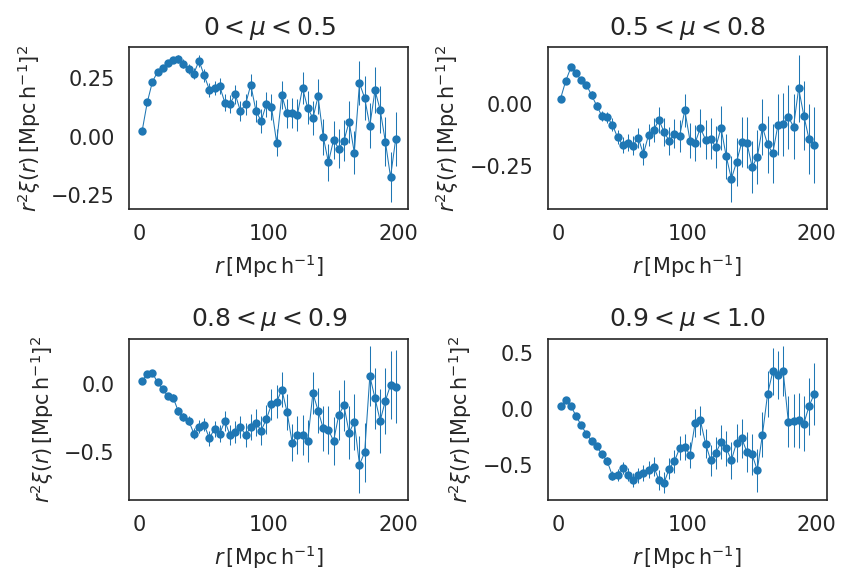

In [14]:
mu = [[0,0.5],[0.5,0.8],[0.8,0.9],[0.9,1.0]]
plt.figure(dpi=150)
for i in range(len(mu)):
    w = picca.wedgize.wedge(mumin=mu[i][0],mumax=mu[i][1]) # To make plots of other wedges modify accordingly
    w.wedge(da,co)
    data_wedge = w.wedge(da,co)
    coef = data_wedge[0]**2
    plt.subplot(221+i)
    plt.errorbar(data_wedge[0],coef*data_wedge[1],yerr=coef*np.sqrt(np.diag(data_wedge[2])),marker='.',linewidth=0.5)
    plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$")
    plt.ylabel(r"$r^2\xi(r) \, [\mathrm{Mpc \, h^{-1}}]^2$")
    plt.title(r'$'+str(mu[i][0])+'<\mu<$'+str(mu[i][1]));
plt.subplots_adjust(hspace=0.8,
                    wspace=.5)

Text(0, 0.5, '$r^2\\xi(r) \\, [\\mathrm{Mpc \\, h^{-1}}]^2$')

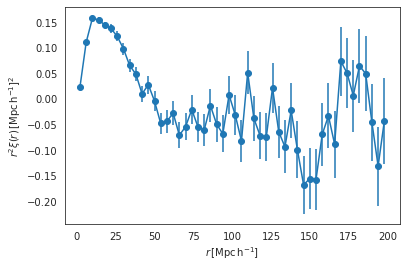

In [15]:
w = picca.wedgize.wedge(mumin=0.,mumax=1.0) # To make plots of other wedges modify accordingly
w.wedge(da,co)
data_wedge = w.wedge(da,co)
coef = data_wedge[0]**2
plt.errorbar(data_wedge[0],coef*data_wedge[1],yerr=coef*np.sqrt(np.diag(data_wedge[2])),marker='o')
plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$")
plt.ylabel(r"$r^2\xi(r) \, [\mathrm{Mpc \, h^{-1}}]^2$")



# Fiting the data

#### To run the picca fitter first we need to generate a couple of ini files. In the script folder you can find the config_cf.ini and chi2.ini files

#### Next we can plot the data and the fits

In [16]:
import h5py

In [17]:
data_fits = h5py.File('data/results_DR16.h5','r')

In [18]:
data_fits.keys()

<KeysViewHDF5 ['LYA(LYA)xLYA(LYA)', 'best fit']>

In [19]:
data_fits['LYA(LYA)xLYA(LYA)']['fit']

<HDF5 dataset "fit": shape (2500,), type "<f4">

In [20]:
fit = data_fits['LYA(LYA)xLYA(LYA)']['fit'][:]

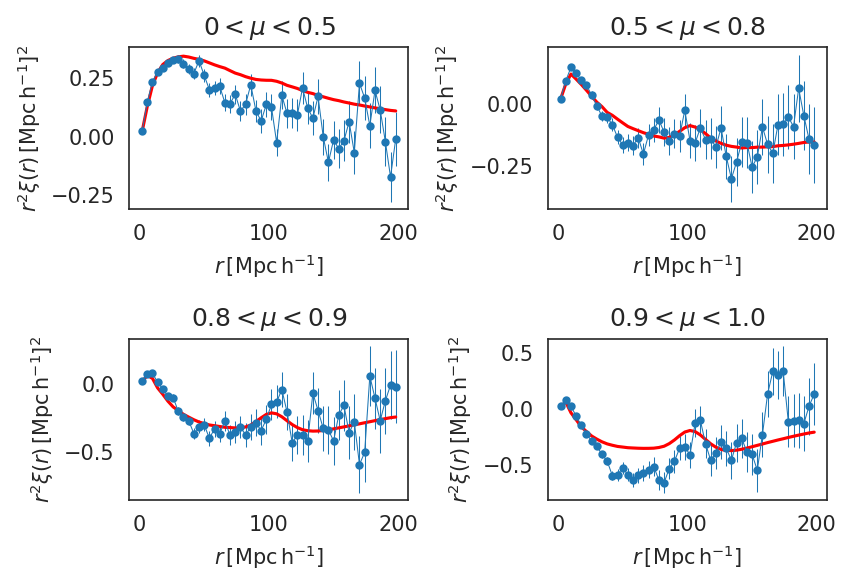

In [21]:
mu = [[0,0.5],[0.5,0.8],[0.8,0.9],[0.9,1.0]]
plt.figure(dpi=150)
for i in range(len(mu)):
    w = picca.wedgize.wedge(mumin=mu[i][0],mumax=mu[i][1],absoluteMu=True) # To make plots of other wedges modify accordingly
    #w.wedge(da,co)
    data_wedge = w.wedge(da,co)
    coef = data_wedge[0]**2
    fit_wedge = w.wedge(fit,co)
    coef_fit = fit_wedge[0]**2
    plt.subplot(221+i)
    plt.errorbar(data_wedge[0],coef*data_wedge[1],yerr=coef*np.sqrt(np.diag(data_wedge[2])),marker='.',linewidth=0.5);
    plt.plot(fit_wedge[0],coef_fit*fit_wedge[1],'r');
    plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$")
    plt.ylabel(r"$r^2\xi(r) \, [\mathrm{Mpc \, h^{-1}}]^2$")
    plt.title(r'$'+str(mu[i][0])+'<\mu<$'+str(mu[i][1]));
plt.subplots_adjust(hspace=0.8,
                    wspace=.5)

Text(0, 0.5, '$r^2\\xi(r) \\, [\\mathrm{Mpc \\, h^{-1}}]^2$')

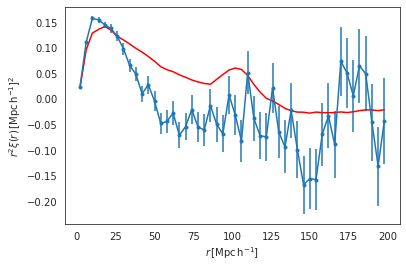

In [22]:
w = picca.wedgize.wedge(mumin=0.,mumax=1.0) # To make plots of other wedges modify accordingly
w.wedge(da,co)
data_wedge = w.wedge(da,co)
fit_wedge = w.wedge(fit,co)
coef = data_wedge[0]**2
coef_fit = fit_wedge[0]**2
plt.errorbar(data_wedge[0],coef*data_wedge[1],yerr=coef*np.sqrt(np.diag(data_wedge[2])),marker='.')
plt.plot(fit_wedge[0],coef*fit_wedge[1],'r')
plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$")
plt.ylabel(r"$r^2\xi(r) \, [\mathrm{Mpc \, h^{-1}}]^2$")